In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('Reddit_Comments_7M_2019.csv')

C:\Users\Adrien\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df

,all_awardings,author,author_cakeday,author_created_utc,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,...,parent_id,permalink,retrieved_on,score,send_replies,stickied,subreddit,subreddit_id,total_awards_received,updated_utc
0,NaN,jayburd13,NaN,1.401375e+09,NaN,NaN,[],NaN,NaN,NaN,...,t3_ab8wps,/r/leagueoflegends/comments/ab8wps/whats_the_b...,1546300806,1,True,False,leagueoflegends,t5_2rfxx,NaN,1.546301e+09
1,NaN,seifyk,NaN,1.375508e+09,NaN,750k party,[],06a2fafc-f4fd-11e8-b863-0e39835cd282,Genuine 750k Party Pin,dark,...,t1_ecz96p9,/r/GlobalOffensive/comments/aaz48j/thorins_top...,1546300809,1,True,False,GlobalOffensive,t5_2sqho,NaN,1.546301e+09
2,NaN,ClingerOn,NaN,1.540412e+09,NaN,NaN,[],NaN,NaN,NaN,...,t1_ecz5udy,/r/hiphopheads/comments/ab966a/machine_gun_kel...,1546300813,1,True,False,hiphopheads,t5_2rh4c,NaN,1.546301e+09
3,NaN,SushiStood,NaN,1.465989e+09,NaN,750k party,[],06a2fafc-f4fd-11e8-b863-0e39835cd282,Genuine 750k Party Pin,dark,...,t3_abcrwy,/r/GlobalOffensive/comments/abcrwy/alttab/ecza...,1546300814,1,True,False,GlobalOffensive,t5_2sqho,NaN,1.546301e+09
4,NaN,bbjimin,NaN,1.487492e+09,NaN,nidalee,"[{'e': 'text', 't': 'peanut best girl - SKT화이팅...",7c4fb678-baa1-11e8-9836-0ec6dedb3898,peanut best girl - SKT화이팅! - CJ Flame :hearteyes:,dark,...,t1_eczav82,/r/leagueoflegends/comments/aba6t3/i_played_ov...,1546300819,1,True,False,leagueoflegends,t5_2rfxx,NaN,1.546301e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7674994,[],fullback133,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,...,t3_c7l96l,/r/leagueoflegends/comments/c7l96l/how_can_i_g...,1561939359,1,True,False,leagueoflegends,t5_2rfxx,0.0,1.562026e+09
7674995,[],Koteric,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,...,t1_esf2ay0,/r/MechanicalKeyboards/comments/c7h0eg/miami_t...,1561939360,1,True,False,MechanicalKeyboards,t5_2ugo7,0.0,1.562026e+09
7674996,[],kernevez,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,...,t1_esfy9i8,/r/leagueoflegends/comments/c7gbiq/g2_jankos_o...,1561939361,12,True,False,leagueoflegends,t5_2rfxx,0.0,1.562026e+09
7674997,[],TheGamingSponge,NaN,NaN,NaN,NaN,"[{'a': ':oc:', 'e': 'emoji', 'u': 'https://emo...",58c61264-fd7d-11e8-9454-0e05befcf792,:oc: :leblanc:,dark,...,t1_esf2waw,/r/leagueoflegends/comments/c7g23t/rioter_snat...,1561939363,5,True,False,leagueoflegends,t5_2rfxx,0.0,1.562026e+09


In [4]:
df = df[df['body'].notnull()]

## Round 1

I was able to pull 681000 comments from the following subreddits:
* leagueoflegends
* globaloffensive
* calpoly
* programmerhumor
* hiphopheads
* seattlewa
* indieheads
* malefashionadvice
* frugalmalefashion
* fantanoforever
* mechanicalkeyboards
* android
* cscareerquestions
* soccer
* nba
* movies
* kanye

Between March 1st and March 7th, 2020.

This took me around 50 minutes of calling the Pushshift API because I can only call 1000 comments at a time.

I ended up scrapping /r/nba and /r/soccer because there were so many of them, and I wanted to scrape comments quicker than that.



In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MaxAbsScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

In [6]:
df_focus = df[['body', 'subreddit']].dropna().sample(1000000)
df_focus = df_focus[(df_focus['subreddit'] == 'leagueoflegends') | (df_focus['subreddit'] == 'hiphopheads') | (df_focus['subreddit'] == 'MechanicalKeyboards')]

X_train = df_focus[['body']]
y_train = df_focus['subreddit']

X_train = df_focus[['body']].sample(frac=.7)
y_train = df_focus['subreddit'].loc[X_train.index]

X_test = df_focus[['body']].drop(X_train.index)
y_test = df_focus['subreddit'].drop(X_train.index)

In [10]:
X_train, y_train, X_test, y_test

(                                                      body
 3962980  &gt;This sub is irritatingly picky and minute....
 6744406  I think yes, you need a certain look to pull o...
 2468904  I have both, but I find myself wearing the sue...
 2539185                                The jacket is navy 
 3880988  Question: "if you are from Europe, where do yo...
 ...                                                    ...
 238703   I'm 5'5" 145 pounds athletic build I used to b...
 1405781  Nobody needs two chains. Unless you're 2chainz...
 103659   Personal preference, I follow the sport coat a...
 5408314  Ah, neat. They're not my type of glasses but t...
 3522621  If you can, buy a Jason Mark set. I bought one...
 
 [182028 rows x 1 columns], 3962980    malefashionadvice
 6744406    malefashionadvice
 2468904    malefashionadvice
 2539185    malefashionadvice
 3880988    malefashionadvice
                  ...        
 238703     malefashionadvice
 1405781    malefashionadvice
 103659    

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
ct = make_column_transformer(
  (CountVectorizer(ngram_range=(1,2), max_features=100), 'body'),
  remainder='passthrough'
)

pipeline = make_pipeline(
    ct,
    #StandardScaler(with_mean=False),
    RandomForestClassifier(criterion='entropy', max_features='sqrt', n_jobs=-1, n_estimators = 100)
)

pipeline.fit(X_train, y_train)

In [55]:
!python -m pip install --upgrade pip
!pip3 install xgboost

  Found existing installation: pip 19.2.3
    Uninstalling pip-19.2.3:
      Successfully uninstalled pip-19.2.3


In [60]:
import xgboost as xgb

ct = make_column_transformer(
  (TfidfVectorizer(ngram_range=(1,2), max_features=500), 'body'),
  remainder='passthrough'
)

pipeline = make_pipeline(
    ct,
    #StandardScaler(with_mean=False),
    xgb.XGBClassifier(n_jobs=-1, n_estimators=500)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
    

In [61]:
ypred = pipeline.predict(X_test)
accuracy_score(y_test, ypred)

0.8050954476907421

In [ ]:
get_scores(y_test, ypred, ['leagueoflegends', 'hiphopheads', 'MechanicalKeyboards'])

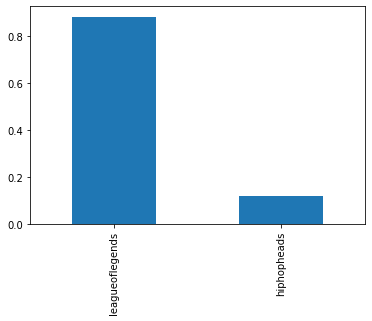

In [59]:
pd.Series(ypred).value_counts(normalize=True).plot.bar()

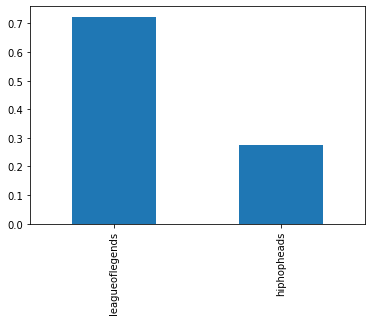

In [43]:
pd.Series(y_test).value_counts(normalize=True).plot.bar()

In [55]:
ypred = pipeline.predict(X_test)
accuracy_score(y_test, ypred)

0.3089077276151688

In [32]:
def get_scores(y_test, ypred, labels):
    print("Accuracy:", accuracy_score(y_test, ypred))
    for label in labels:
        print("Precision for", label + ":", precision_score(y_test, ypred, pos_label=label))
        print("Recall for", label + ":", recall_score(y_test, ypred, pos_label=label))

In [39]:
get_scores(y_test, ypred, ['leagueoflegends', 'hiphopheads'])

Accuracy: 0.7975736547208906
Precision for leagueoflegends: 0.8111021662763466
Recall for leagueoflegends: 0.9389184930404358
Precision for hiphopheads: 0.7277807143396512
Recall for hiphopheads: 0.4275289994898751


In [51]:
test = pd.DataFrame([['']], columns = ['body'])

pipeline.predict_proba(test)

array([[0.3380371, 0.6619629]])

In [63]:
get_scores(y_test, ypred, ['leagueoflegends', 'hiphopheads'])

Accuracy: 0.8050954476907421
Precision for leagueoflegends: 0.8165581436321326
Recall for leagueoflegends: 0.9423495624327553
Precision for hiphopheads: 0.7470542318700517
Recall for hiphopheads: 0.44576041874598
